In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import time

from plotting.constants import METRIC_LABELS
from src.data_utils import load_data
from src.experiment_configs import LAMBDA_CONFIGS
from src.experiment_utils import set_random_seed, set_precision, get_full_krr
from src.opts import ASkotchV2, EigenPro2

In [16]:
seed = 0
precision = "float32"
device = "cuda:0"
dataset = "qm9"
task = "regression"
metric = "test_smape"
# kernel_params = {"type": "l1_laplace", "sigma": 20.0} # mnist
kernel_params = {"type": "l1_laplace", "sigma": 5120.0} # qm9
# kernel_params = {"type": "rbf", "sigma": 0.1} # covtype_binary
# kernel_params = {"type": "rbf", "sigma": 3.0} # susy
# kernel_params = {"type": "matern", "nu": 2.5, "sigma": 120 ** 0.5} # salicylic
# kernel_params = {"type": "matern", "nu": 2.5, "sigma": 105 ** 0.5} # toluene
# kernel_params = {"type": "matern", "nu": 2.5, "sigma": 36 ** 0.5} # ethanol
# kernel_params = {"type": "matern", "nu": 2.5, "sigma": 66 ** 0.5} # benzene
# kernel_params = {"type": "matern", "nu": 2.5, "sigma": 36 ** 0.5} # malonaldehyde
max_iters = 2000

if metric in ["rel_residual", "test_smape"]:
    plot_fn = plt.semilogy
else:
    plot_fn = plt.plot

In [17]:
set_random_seed(seed)
set_precision(precision)

In [18]:
def run_exp(opt, max_iters):
    times = []
    metrics_hist = []
    for i in range(max_iters):
        ts = time.time()
        opt.step()
        times.append(time.time() - ts)
        if i % 200 == 0:
            metrics = opt.model.compute_metrics(opt.model.w, log_test_only=False)
            metrics_hist.append((i, metrics))
            print(f"iter {i} / {max_iters}, metrics: {metrics}")

    times = np.array(times)
    cum_times = np.cumsum(times)
    return cum_times, metrics_hist

In [19]:
Xtr, Xtst, ytr, ytst = load_data(dataset, seed=seed, device=device)

In [20]:
model = get_full_krr(Xtr, ytr, Xtst, ytst, kernel_params, True, 0, task, device)
opt = EigenPro2(model, bg=None, block_sz=12000, r=100)

In [21]:
cum_times_eigenpro2, metrics_hist_eigenpro2 = run_exp(opt, max_iters)

iter 0 / 2000, metrics: {'rel_residual': tensor(6958.6323, device='cuda:0'), 'train_loss': tensor(1.0968e+09, device='cuda:0'), 'test_mse': 1041225216.0, 'test_msre': 25136574.0, 'test_rmse': 32268.02156934943, 'test_rmsre': 5013.638798318044, 'test_smape': 2.0, 'test_mae': 45623.32421875}
iter 200 / 2000, metrics: {'rel_residual': tensor(nan, device='cuda:0'), 'train_loss': tensor(nan, device='cuda:0'), 'test_mse': nan, 'test_msre': nan, 'test_rmse': nan, 'test_rmsre': nan, 'test_smape': nan, 'test_mae': nan}
iter 400 / 2000, metrics: {'rel_residual': tensor(nan, device='cuda:0'), 'train_loss': tensor(nan, device='cuda:0'), 'test_mse': nan, 'test_msre': nan, 'test_rmse': nan, 'test_rmsre': nan, 'test_smape': nan, 'test_mae': nan}
iter 600 / 2000, metrics: {'rel_residual': tensor(nan, device='cuda:0'), 'train_loss': tensor(nan, device='cuda:0'), 'test_mse': nan, 'test_msre': nan, 'test_rmse': nan, 'test_rmsre': nan, 'test_smape': nan, 'test_mae': nan}


KeyboardInterrupt: 

In [9]:
model = get_full_krr(Xtr, ytr, Xtst, ytst, kernel_params, True, LAMBDA_CONFIGS[dataset] * Xtr.shape[0], task, device)
b = model.n // 100
opt = ASkotchV2(model, block_sz=b, sampling_method="uniform", precond_params={"type": "nystrom", "r": 100, "rho": "damped"}, accelerated=True)

In [10]:
cum_times_askotchv2, metrics_hist_askotchv2 = run_exp(opt, max_iters)

[KeOps] Generating code for Sum_Reduction reduction (with parameters 0) of formula (((1+(c*Sqrt(Sum((a-b)**2)))/d)+(5*Sqrt(Sum((a-b)**2))**2)/e)*Exp(-((c*Sqrt(Sum((a-b)**2)))/d)))*f with a=Var(0,66,0), b=Var(1,66,1), c=Var(2,1,2), d=Var(3,1,2), e=Var(4,1,2), f=Var(5,100,1) ... OK
iter 0 / 2000, metrics: {'rel_residual': tensor(0.8050, device='cuda:0'), 'train_loss': tensor(-1742.5461, device='cuda:0'), 'test_mse': 1.7773957252502441, 'test_msre': 33486.453125, 'test_rmse': 1.3331900559373537, 'test_rmsre': 182.9930411928279, 'test_smape': 1.26032555103302, 'test_mae': 1.477408528327942}
iter 200 / 2000, metrics: {'rel_residual': tensor(0.0840, device='cuda:0'), 'train_loss': tensor(-35363.4766, device='cuda:0'), 'test_mse': 0.02099956013262272, 'test_msre': 3495.03271484375, 'test_rmse': 0.1449122497673082, 'test_rmsre': 59.11880170338156, 'test_smape': 0.2218766212463379, 'test_mae': 0.15877699851989746}
iter 400 / 2000, metrics: {'rel_residual': tensor(0.0489, device='cuda:0'), 'trai

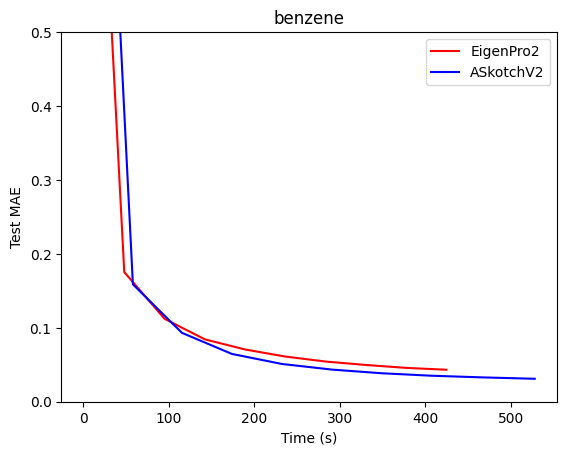

In [ ]:
plt.figure()
cum_times_eigenpro2_iter = []
test_mae_eigenpro2 = []
cum_times_askotchv2_iter = []
test_mae_askotchv2 = []
for iter, metric_dict in metrics_hist_eigenpro2:
    cum_times_eigenpro2_iter.append(cum_times_eigenpro2[iter])
    test_mae_eigenpro2.append(metric_dict[metric])
for iter, metric_dict in metrics_hist_askotchv2:
    cum_times_askotchv2_iter.append(cum_times_askotchv2[iter])
    test_mae_askotchv2.append(metric_dict[metric])
plot_fn(cum_times_eigenpro2_iter, test_mae_eigenpro2, "r-", label="EigenPro2")
plot_fn(cum_times_askotchv2_iter, test_mae_askotchv2, "b-", label="ASkotchV2")
plt.xlabel("Time (s)")
plt.ylabel(METRIC_LABELS[metric])
plt.ylim(0.0, 0.5)
plt.title(dataset)
plt.legend()
plt.savefig(f"{dataset}.pdf")